In [1]:
!ls /content/drive/MyDrive/InceptezFiles/COVID-19.zip

ls: cannot access '/content/drive/MyDrive/InceptezFiles/COVID-19.zip': No such file or directory


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip /content/drive/MyDrive/InceptezFiles/COVID-19.zip

Archive:  /content/drive/MyDrive/InceptezFiles/COVID-19.zip
  inflating: COVID-CT-MetaInfo.xlsx  
  inflating: CT_COVID/2019-novel-Coronavirus-severe-adult-respiratory-dist_2020_International-Jour-p3-89%0.png  
  inflating: CT_COVID/2019-novel-Coronavirus-severe-adult-respiratory-dist_2020_International-Jour-p3-89%1.png  
  inflating: CT_COVID/2019-novel-Coronavirus-severe-adult-respiratory-dist_2020_International-Jour-p3-91.png  
  inflating: CT_COVID/2020.01.24.919183-p27-132.png  
  inflating: CT_COVID/2020.01.24.919183-p27-133.png  
  inflating: CT_COVID/2020.01.24.919183-p27-134.png  
  inflating: CT_COVID/2020.01.24.919183-p27-135.png  
  inflating: CT_COVID/2020.02.10.20021584-p6-52%0.png  
  inflating: CT_COVID/2020.02.10.20021584-p6-52%1.png  
  inflating: CT_COVID/2020.02.10.20021584-p6-52%10.png  
  inflating: CT_COVID/2020.02.10.20021584-p6-52%11.png  
  inflating: CT_COVID/2020.02.10.20021584-p6-52%12.png  
  inflating: CT_COVID/2020.02.10.20021584-p6-52%13.png  
  inflati

In [4]:
!pip install torchinfo

In [5]:
import os
import glob
import sklearn
from sklearn.model_selection import train_test_split
import PIL
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchinfo import summary

import torch.optim as optim
from IPython.display import Image
from torch.utils.data import DataLoader, Dataset

from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms

import cv2

In [6]:
device = torch.device("cuda")

In [7]:
device

device(type='cuda')

In [8]:
random_seed = 124
np.random.seed(random_seed)

torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True

In [9]:
pos_files = glob.glob("CT_COVID/*.*")

In [11]:
neg_files = glob.glob("CT_NonCOVID/*.*")

In [15]:
images = pos_files+neg_files
labels = np.array([1] * len(pos_files)+[0]*len(neg_files))

In [17]:
images_tv, images_test,y_tv,y_test = train_test_split(images,labels,shuffle = True,test_size = 0.2,random_state=124)

In [18]:
images_train, images_val,y_train,y_val = train_test_split(images_tv,y_tv,shuffle = True,test_size = 0.25,random_state=124)

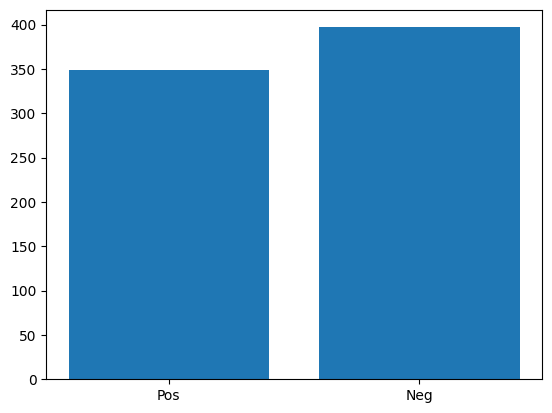

In [19]:
num_pos, num_neg = len(pos_files),len(neg_files)

plt.bar(['Pos','Neg'],[num_pos,num_neg])
plt.show()

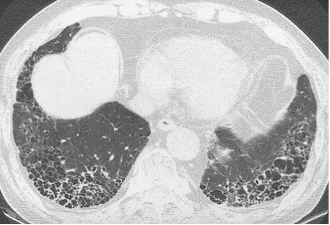

In [26]:
Image(images_train[6])

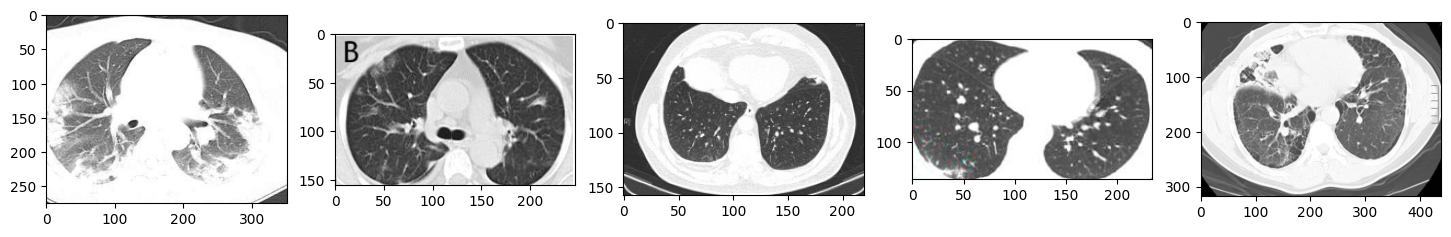

In [28]:
im = [cv2.imread(images_train[i]) for i in range(20,25)]

fig, ax = plt.subplots(ncols = 5,figsize=(18,5))
for i in range(len(im)):
  ax[i].imshow(im[i],cmap = 'gray')

plt.show()

In [29]:
im[0].shape

(275, 351, 3)

In [30]:
im[1].shape

(155, 247, 3)

In [31]:
im[2].shape

(158, 220, 3)

In [32]:
class CT_Dataset(Dataset):
  def __init__(self, img_path, img_labels, img_transforms=None,grayscale = True):
    self.img_path = img_path
    self.img_labels = torch.Tensor(img_labels)
    if (img_transforms is None) & (grayscale == True):
      self.transforms = transforms.Compose([transforms.Grayscale(),transforms.resize([250,250])])
    elif grayscale == False:
      self.transforms = transforms.Compose([transforms.resize([250,250]),transforms.ToTensor()])

    def __getitem__(self,index):
      cur_path = self.img_path[index]
      cur_img = PIL.Image.open(cur_path).convert("RGB")
      cur_img = self.transforms(cur_img)

      return cur_img, self.img_labels[index]
    def __len__(self):
      return len(self.img_path)

In [39]:
#define CNN Module
class Convnet(nn.Module):
  def __init__(self, dropout = 0.5):
    super(Convnet,self).__init__()
    #input = (num_batches,1,250,250)
    self.convnet = nn.Sequential(
        nn.Conv2d(in_channels = 1,out_channels = 64,kernel_size = 3,),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2),

        nn.Conv2d(in_channels = 64,out_channels = 128,kernel_size = 3,),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2),

        nn.Conv2d(in_channels = 128,out_channels = 256,kernel_size = 3,),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2),

        nn.Conv2d(in_channels = 256,out_channels = 512,kernel_size = 3,),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2),

        nn.Conv2d(in_channels = 512,out_channels = 512,kernel_size = 3,),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2),
        nn.Flatten() #(num_batches,)
        )

    self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(in_features = 12800,out_features = 512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(in_features = 512,out_features = 256),
            nn.ReLU(),
            nn.Linear(in_features = 256,out_features = 128),
            nn.ReLU(),
            nn.Linear(in_features = 128,out_features = 1),
        )
  def forward(self,x):
    x = self.convnet(x)
    x = self.classifier(x)
    return x

In [40]:
vision_model = Convnet()
summary(vision_model,(32,1,250,250))

Layer (type:depth-idx)                   Output Shape              Param #
Convnet                                  [32, 1]                   --
├─Sequential: 1-1                        [32, 12800]               --
│    └─Conv2d: 2-1                       [32, 64, 248, 248]        640
│    └─BatchNorm2d: 2-2                  [32, 64, 248, 248]        128
│    └─ReLU: 2-3                         [32, 64, 248, 248]        --
│    └─MaxPool2d: 2-4                    [32, 64, 124, 124]        --
│    └─Conv2d: 2-5                       [32, 128, 122, 122]       73,856
│    └─BatchNorm2d: 2-6                  [32, 128, 122, 122]       256
│    └─ReLU: 2-7                         [32, 128, 122, 122]       --
│    └─MaxPool2d: 2-8                    [32, 128, 61, 61]         --
│    └─Conv2d: 2-9                       [32, 256, 59, 59]         295,168
│    └─BatchNorm2d: 2-10                 [32, 256, 59, 59]         512
│    └─ReLU: 2-11                        [32, 256, 59, 59]         --
│ 